# Código de extracción de características 


## 1. Importación del dataset desde Github

En esta sección se procede importar las librerías necesarias para el análisis y a cargar el conjunto de datos directamente desde el repositorio de GitHub donde se encuentra almacenado. Para ello se utiliza la versión “raw” del archivo, lo cual permite a pandas leerlo como un archivo CSV estándar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [2]:
# cargue del dataset desde github
url = "https://raw.githubusercontent.com/Dovallec/Heart_Failure_Analysis/master/data/heart.csv"
df = pd.read_csv(url)
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## 2. Revisión inicial de la base de datos
Antes de cualquier proceso de extracción de características, es indispensable realizar una inspección preliminar del conjunto de datos. En este bloque se evalúa la estructura del DataFrame, los tipos de datos, la presencia de valores faltantes y las estadísticas descriptivas básicas. El propósito es obtener una comprensión inicial del contenido y detectar posibles inconsistencias que puedan afectar las fases posteriores de preprocesamiento o modelamiento.

In [3]:
df.info()
print()
print(df.isnull().sum())
print()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
S

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## 3. Codificación de las variables categóricas
Dado que el conjunto de datos contiene varias variables categóricas de tipo cadena, es necesario convertirlas a una representación numérica antes de aplicar técnicas de selección de características basadas en pruebas estadísticas. En este paso se identifican las columnas categóricas y se aplica codificación mediante variables ficticias (get_dummies), manteniendo una referencia binaria para cada categoría relevante. El objetivo es obtener una matriz de predictores completamente numérica que pueda ser utilizada por SelectKBest.

In [4]:
# Variable objetivo
target_col = "HeartDisease"
# Separar predictores y objetivo
X = df.drop(columns=[target_col])
y = df[target_col]
# Columnas categóricas
cat_cols = ["Sex", "ChestPainType", "RestingECG", "ExerciseAngina", "ST_Slope"]
# One-hot encoding para variables categóricas
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

X_encoded.head()


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,True,False,True,False,True,False,False,False,True


## 4. Visualización exploratoria básica
En esta sección se generan dos visualizaciones exploratorias. En primer lugar, se representa la distribución de la variable objetivo para evaluar el balance entre las clases con y sin enfermedad cardíaca. 

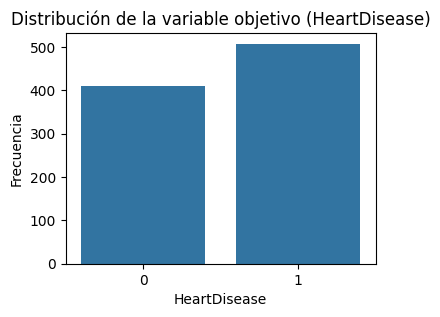

In [5]:
# Distribución de la variable objetivo
plt.figure(figsize=(4,3))
sns.countplot(x=y)
plt.title("Distribución de la variable objetivo (HeartDisease)")
plt.xlabel("HeartDisease")
plt.ylabel("Frecuencia")
plt.show()

En general, se observa que en este conjunto de datos no se presenta un desbalance de clases.

Posteriormente, se calcula una matriz de correlación sobre la versión codificada de los predictores y se visualiza mediante un mapa de calor. Estas gráficas proporcionan una primera aproximación a las relaciones entre variables y a la estructura del problema de clasificación.

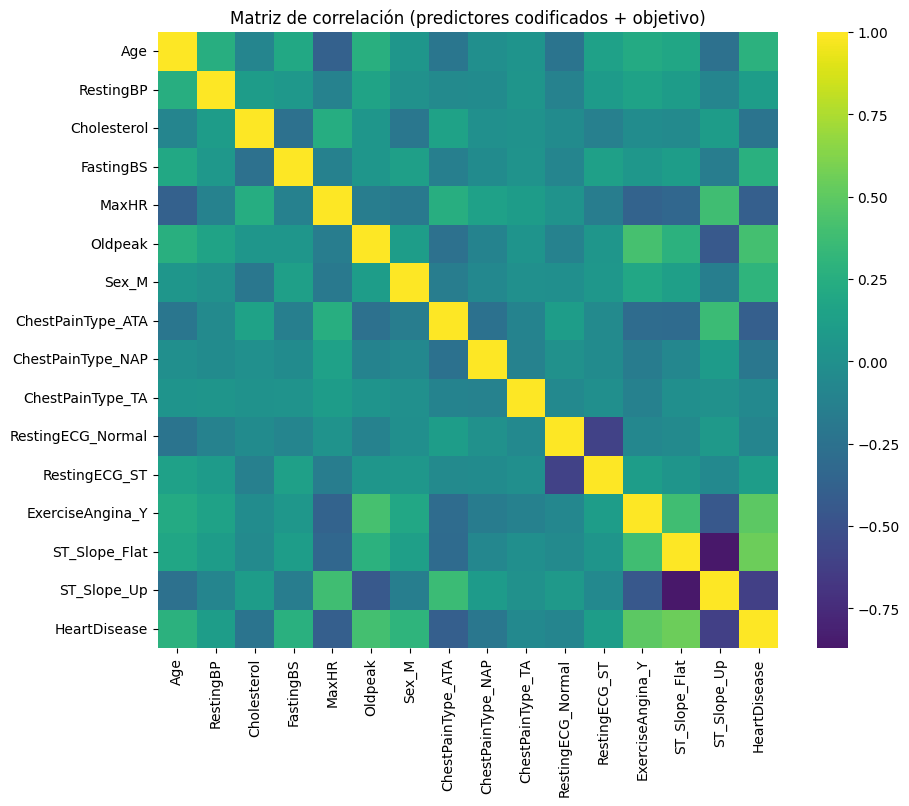

In [6]:
# Matriz de correlación sobre las variables numéricas codificadas
plt.figure(figsize=(10,8))
corr_matrix = X_encoded.join(y).corr()
sns.heatmap(corr_matrix, cmap="viridis", center=0)
plt.title("Matriz de correlación (predictores codificados + objetivo)")
plt.show()

En la matriz de correlación realizada, se observa que las variables categóricas asociadas al dolor de pecho, la pendiente del segmento ST y la presencia de angina inducida por ejercicio presentan correlaciones relativamente altas y positivas con la enfermedad cardíaca, lo que sugiere una relación directa con el diagnóstico. Asimismo, variables como MaxHR exhiben correlaciones negativas moderadas con la presencia de enfermedad, lo cual coincide con la evidencia clínica de que una menor frecuencia cardíaca máxima alcanzada suele asociarse con mayor riesgo.

## 5. División de los datos en entrenamiento y prueba
Para garantizar una evaluación adecuada de los modelos que se construyan posteriormente y evitar fuga de información, se divide el conjunto de datos en subconjuntos de entrenamiento y prueba. La partición se realiza sobre la matriz codificada de predictores y la variable objetivo, reservando una fracción de los datos para evaluación independiente en etapas posteriores del flujo de trabajo de Machine Learning.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)


## 6. Selección de características con SelectKBest y ANOVA F-test
A continuación, se aplica la técnica de selección univariante SelectKBest utilizando como función de puntuación el estadístico ANOVA F-test (f_classif). Este procedimiento evalúa de forma independiente cada predictor numérico frente a la variable objetivo y calcula un F-score que mide la capacidad de la característica para discriminar entre pacientes con y sin enfermedad cardíaca. Posteriormente se seleccionan las k características con mayor F-score, constituyendo un subconjunto reducido de variables con alta relevancia estadística.

### 6.1 Cálculo

In [8]:
# considerando las dimensiones de la base de datos, se selecciona una dimensión de 8 características
k = 8

selector = SelectKBest(score_func=f_classif, k=k)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel  = selector.transform(X_test)

selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]

print("Número total de características:", X_train.shape[1])
print("Número de características seleccionadas:", k)
print("\nCaracterísticas seleccionadas:")
print(selected_features)

Número total de características: 15
Número de características seleccionadas: 8

Características seleccionadas:
Index(['FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ATA',
       'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')


### 6.2 Visualización
Con el objetivo de interpretar y justificar la selección realizada, se construye una gráfica de barras que muestra los valores F-score asociados a cada predictor. Esta representación permite observar de manera ordenada qué variables presentan mayor poder discriminante respecto a la presencia de enfermedad cardíaca. Un F-score elevado indica diferencias significativas entre las clases para dicha característica, mientras que valores bajos sugieren una contribución menor al problema de clasificación.

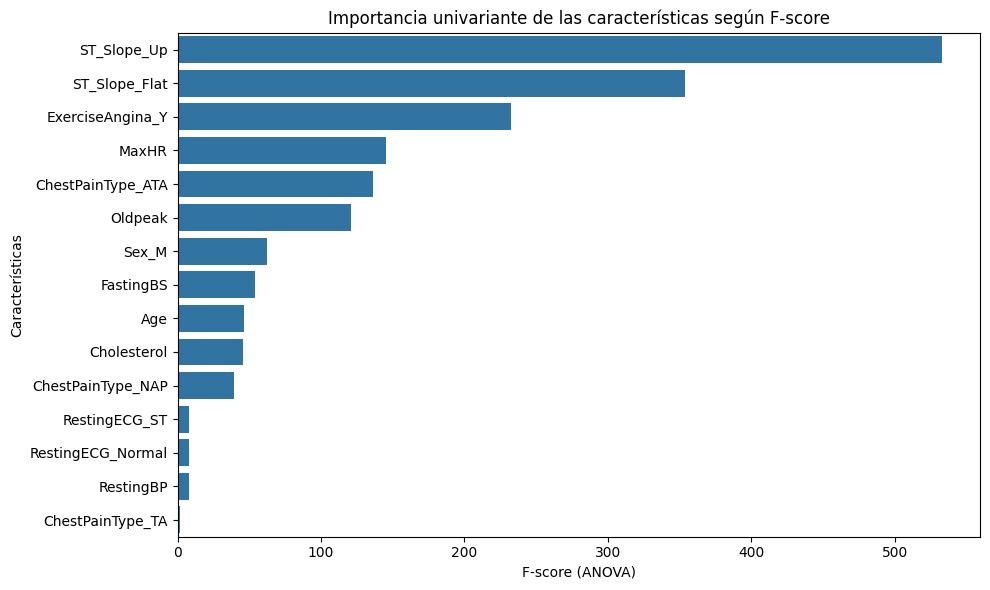

In [9]:
scores = selector.scores_
feature_names = X_train.columns

score_df = pd.DataFrame({
    "feature": feature_names,
    "f_score": scores
}).sort_values("f_score", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=score_df, x="f_score", y="feature")
plt.title("Importancia univariante de las características según F-score")
plt.xlabel("F-score (ANOVA)")
plt.ylabel("Características")
plt.tight_layout()
plt.show()

## 7. Selección de características mediante información mutua
En esta sección se implementa una segunda técnica de selección univariante de características utilizando la función mutual_info_classif como criterio de evaluación dentro de SelectKBest. A diferencia del ANOVA F-test, que asume relaciones principalmente lineales y compara medias entre clases, la información mutua mide la reducción de incertidumbre sobre la variable objetivo al observar una característica concreta y no impone supuestos estrictos sobre la forma de la relación. En términos prácticos, este método permite capturar dependencias potencialmente no lineales entre los predictores y la presencia de enfermedad cardíaca.

### 7.1 Cálculo

In [10]:
k_mi = 8  

mi_selector = SelectKBest(score_func=mutual_info_classif, k=k_mi)
X_train_mi = mi_selector.fit_transform(X_train, y_train)
X_test_mi  = mi_selector.transform(X_test)

mi_mask = mi_selector.get_support()
mi_features = X_train.columns[mi_mask]

print("Número total de características:", X_train.shape[1])
print("Número de características seleccionadas (mutual information):", k_mi)
print("\nCaracterísticas seleccionadas con información mutua:")
print(mi_features)

Número total de características: 15
Número de características seleccionadas (mutual information): 8

Características seleccionadas con información mutua:
Index(['Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'ChestPainType_ATA',
       'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')


### 7.2 Visualización

Con el fin de interpretar los resultados de este segundo enfoque, se construye un gráfico de barras que representa los valores de información mutua asociados a cada predictor. Esta visualización permite comparar de forma directa el grado de dependencia entre cada característica y la variable objetivo.

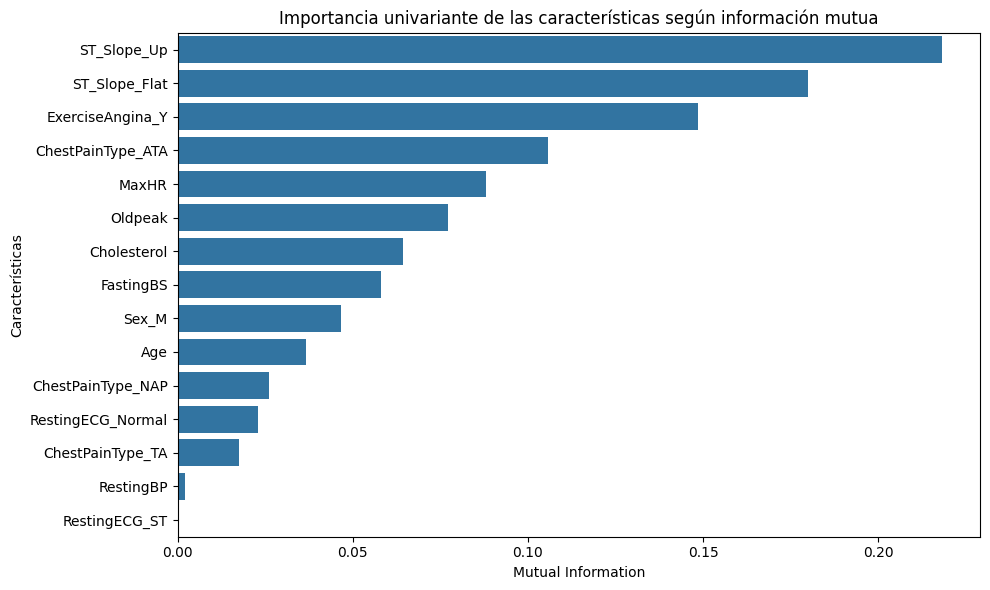

In [11]:
mi_scores = mi_selector.scores_
mi_df = pd.DataFrame({
    "feature": X_train.columns,
    "mi_score": mi_scores
}).sort_values("mi_score", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=mi_df, x="mi_score", y="feature")
plt.title("Importancia univariante de las características según información mutua")
plt.xlabel("Mutual Information")
plt.ylabel("Características")
plt.tight_layout()
plt.show()

## 8. Análisis de los resultados obtenidos por ambos métodos

Los resultados obtenidos mediante ambos métodos de selección univariante, ANOVA F-score e información mutua, muestran un patrón consistente en cuanto a las variables que poseen mayor capacidad predictiva sobre la presencia de enfermedad cardíaca. En ambos casos destacan *ST_Slope_Up*, *ST_Slope_Flat* y *ExerciseAngina_Y* como los predictores más relevantes, lo que sugiere que los cambios en el segmento ST y la angina inducida por ejercicio constituyen señales clínicas particularmente asociadas al diagnóstico. También se observa que variables como *MaxHR*, *Oldpeak* y *ChestPainType_ATA* mantienen niveles de importancia elevados en ambos enfoques, reforzando la estabilidad de su contribución al modelo. Las discrepancias menores entre técnicas, especialmente en valores intermedios, obedecen a las diferencias entre los supuestos estadísticos de ANOVA (linealidad y comparación de medias) y la mayor flexibilidad de la información mutua para capturar dependencias no lineales. En conjunto, los resultados muestran que existe un núcleo estable de características de alto valor predictivo y que ambos métodos convergen en la identificación de las señales más determinantes del problema.


## 9. Modelamiento

### 9.1 XGBOOST

In [12]:
def plot_confusion_matrix_seaborn(cm, classes=['Clase 0', 'Clase 1']):
    """Matriz de confusión elegante con seaborn"""
    plt.figure(figsize=(8, 6))
    
    # Crear heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': 'Cantidad'},
                xticklabels=classes, yticklabels=classes,
                linewidths=2, linecolor='white',
                square=True, annot_kws={'size': 16, 'weight': 'bold'})
    
    plt.title('Matriz de Confusión', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Valor Real', fontsize=12, fontweight='bold')
    plt.xlabel('Valor Predicho', fontsize=12, fontweight='bold')
    plt.tight_layout()
    return plt

In [13]:
model = xgb.XGBClassifier(random_state=42)

In [35]:
param_grid = {
    "n_estimators": [50, 100],
    "eta": [0.5, 0.1, 0.2],
    "max_depth": [3, 5, 6 ],
    "gamma": [0, 1],
    "booster": ["gbtree"],
}

In [36]:
gsearch = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=5,
                    scoring=make_scorer(accuracy_score,
                    greater_is_better=True)).fit(X_train, y_train)

In [37]:
y_pred = gsearch.predict(X_test)

In [38]:
gsearch.best_params_

{'booster': 'gbtree',
 'eta': 0.1,
 'gamma': 1,
 'max_depth': 3,
 'n_estimators': 100}

In [39]:
cm_xgb = confusion_matrix(y_test, y_pred)

In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88        82
           1       0.89      0.91      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



<module 'matplotlib.pyplot' from 'e:\\CURSOS\\Universidad Nacional\\modulo 6\\entregas proyecto\\salud-venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

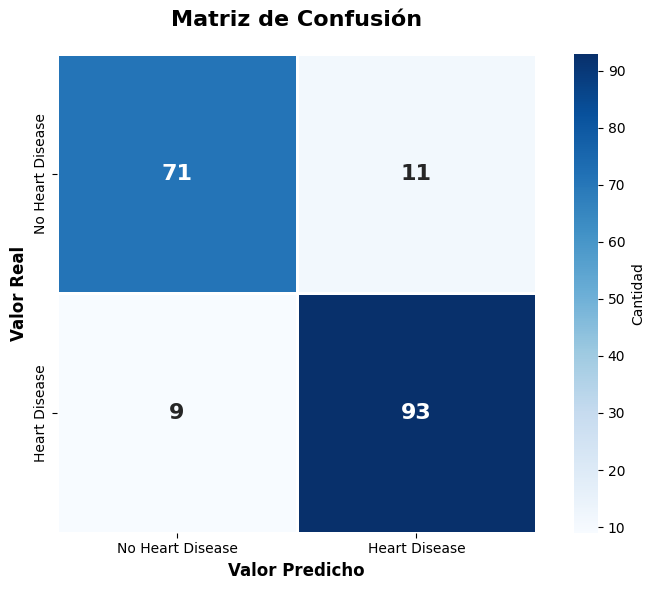

In [20]:
plot_confusion_matrix_seaborn(cm_xgb, classes=['No Heart Disease', 'Heart Disease'])

### 9.2 regresión logística

In [41]:
l_reg = LogisticRegression(random_state=42)
param_grid_lr = {
    'penalty': ['l2'],
    'C': [1.0],
    'solver': ['lbfgs'],
    'max_iter': [100000],
    'class_weight': ['balanced'],
}

gserach_lr = GridSearchCV(estimator=l_reg,
                    param_grid=param_grid_lr,
                    cv=5,
                    scoring=make_scorer(accuracy_score,
                    greater_is_better=True)).fit(X_train, y_train)


In [42]:
gserach_lr.best_params_

{'C': 1.0,
 'class_weight': 'balanced',
 'max_iter': 100000,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [43]:
y_pred_lr = gserach_lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87        82
           1       0.88      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



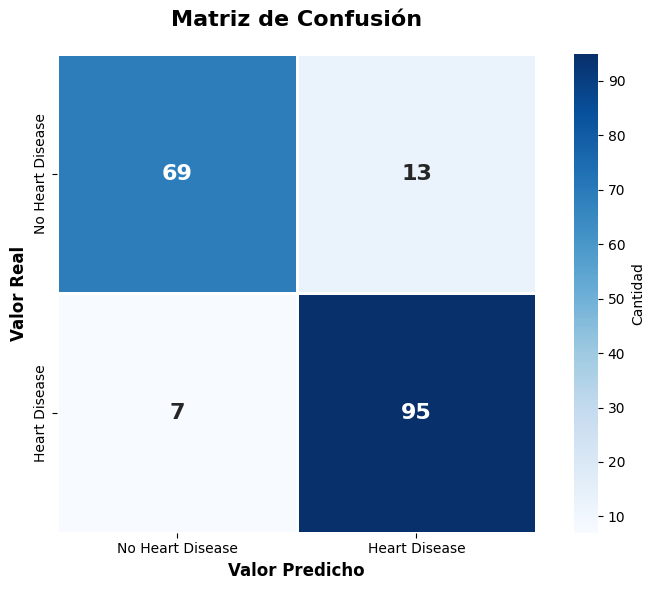

In [24]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
plot_confusion_matrix_seaborn(cm_lr, classes=['No Heart Disease', 'Heart Disease']).show()

### 9.3 Suport Vector Machine

In [28]:
param_grid = {
    "kernel": ["linear"],
    "C": [1.0, 0.1, 0.01],
    "gamma": [1.0, 0.1]
}

In [29]:
gsearch_svc = GridSearchCV(
        estimator=SVC(random_state=42),
        param_grid=param_grid,
        scoring=make_scorer(accuracy_score, greater_is_better=True)
        ).fit(X_train, y_train)

<module 'matplotlib.pyplot' from 'e:\\CURSOS\\Universidad Nacional\\modulo 6\\entregas proyecto\\salud-venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

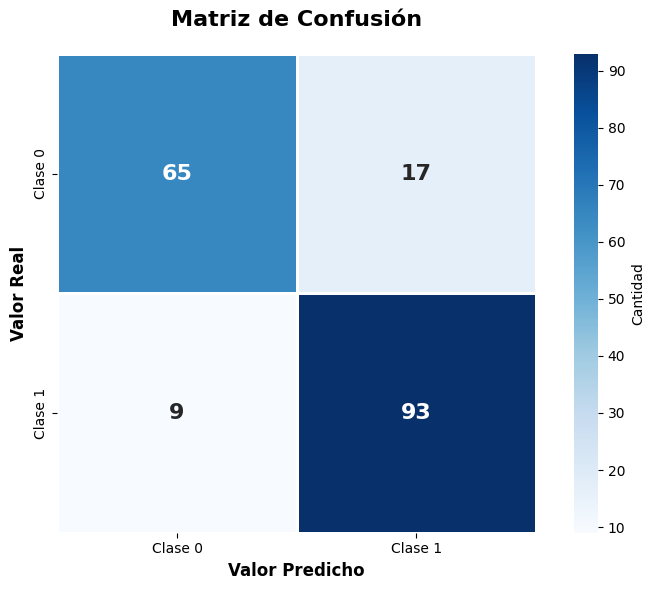

In [31]:
y_pred_svc = gsearch_svc.predict(X_test)
cm_svc = confusion_matrix(y_test, y_pred_svc)
plot_confusion_matrix_seaborn(cm_svc)

In [33]:
print(classification_report(y_test, y_pred_svc))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.86      0.85      0.86       184
weighted avg       0.86      0.86      0.86       184



In [34]:
gsearch_svc.best_params_

{'C': 0.1, 'gamma': 1.0, 'kernel': 'linear'}